## Set up

For this exercise you will need the following libraries

* pandas
* numpy
* scikit-learn
* seaborn
* matplotlib


## The problem

Given imperfect automated processes dealing with large volumes of data, it becomes essential to have a method of identifying unusual cases, so that they can be flagged up for closer inspection. Such cases might be due to:

* Data entry errors or false claims
* Processing errors, for example items that have been misclassified
* A change in the environment, which then needs to be adjusted for
* The occurance of new cases that haven't been seen before (novelties)

The problem of *anomaly detection* is the problem of identifying these cases without flagging up too many cases that are not of concern.

## An example

In this example we are a media company with a registration process for new users. Users are known to give false demographic information, and there is also a chance that data processes may go wrong, creating incorrect behavioural data. This is a good case study for anomaly detection. For example a user may demonstrate behaviour that is inconsistant with her claimed age, thus creating a data anomaly. We will generate some dummy data that we can use to explore the effectiveness of five types of anomaly detection algorithm (all of which are implemented in the python scikit-learn library)

## Simulating some data

In [1]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

#np.random.seed(53728)
np.random.seed(1234)
num_users = 1000

hours_viewed_per_week = np.random.lognormal(1.5, 1., num_users).astype('int')
pct_on_mobile = np.random.beta(1,1,num_users) # uniform
age = np.random.poisson(45,num_users)
income = 5000 + 800 * age +  np.random.normal(0, 2000, num_users) #Creating some correlation
gender = np.random.binomial(1,0.4,num_users)
#Adding relationship between demographics and genre viewing
drama = np.random.beta(1,6,num_users)
num_female = drama[gender==1].shape[0]
drama[gender==1] = np.random.beta(6,1,num_female)
sport = np.random.beta(6,1,num_users)
sport[gender==1] = np.random.beta(1,8,num_female)
comedy = np.random.beta(3,1,num_users)
num_45_plus= age[age>45].shape[0]
comedy[age>45] = np.random.beta(1,3,num_45_plus)


normal_users = pd.DataFrame({'age': age,'gender': gender,'income': income,
                             'hours_viewed_per_week': hours_viewed_per_week,'pct_on_mobile': pct_on_mobile,
                             'drama': drama,'sport': sport,'comedy': comedy,'outlier': [0]*num_users
    })

Let's a have a look at the generated data.

In [2]:
normal_users.head()

,age,gender,income,hours_viewed_per_week,pct_on_mobile,drama,sport,comedy,outlier
0,45,1,40695.589231,7,0.498553,0.918290,0.243323,0.997220,0
1,44,0,40611.071895,1,0.333217,0.166661,0.997029,0.657660,0
2,47,0,44260.327519,18,0.763768,0.042602,0.698173,0.178063,0
3,44,1,39491.697543,3,0.191470,0.373193,0.355908,0.672280,0
4,39,0,35942.121158,2,0.870575,0.086309,0.867559,0.793465,0


Some boxplots and scatterplots confirm that we have succeeded in creating a relationship between gender, age and genre.

C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


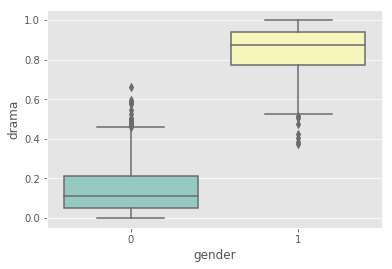

In [3]:
_ = sns.boxplot(x="gender", y="drama", data=normal_users, palette="Set3")

C:\Users\ryanwala\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


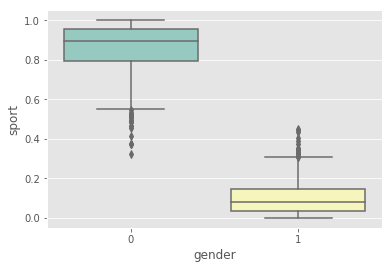

In [4]:
_ = sns.boxplot(x="gender", y="sport", data=normal_users, palette="Set3")

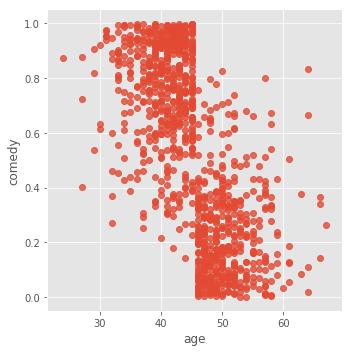

In [5]:
_ = sns.lmplot('age','comedy',data=normal_users,fit_reg=False)

Now let's add some outliers to the data. To insert these outliers into the data set we need an understanding of what is normal for the data set. For that we can use the descriptive statistics.

In [6]:
normal_users.describe()

,age,gender,income,hours_viewed_per_week,pct_on_mobile,drama,sport,comedy,outlier
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0
mean,45.151000,0.402000,41172.029173,6.757000,0.496632,0.427319,0.553803,0.522796,0.0
std,6.617552,0.490547,5634.931941,8.421096,0.295867,0.364084,0.387212,0.321783,0.0
min,24.000000,0.000000,23789.107959,0.000000,0.000161,0.000028,0.000271,0.000212,0.0
25%,41.000000,0.000000,37409.477384,2.000000,0.227169,0.086591,0.107896,0.225362,0.0
50%,45.000000,0.000000,40872.959729,4.000000,0.498536,0.270299,0.737689,0.542230,0.0
75%,50.000000,1.000000,44692.742832,8.000000,0.755869,0.827829,0.920953,0.828948,0.0
max,67.000000,1.000000,57711.214378,71.000000,0.999705,0.999381,0.999856,0.999438,0.0


Let's now add some outliers.

In [7]:
#Some outliers
age = [16, 55, 42, 58, 37, 32]
gender = [1, 1, 1, 0, 0, 0]
income = [10400, 46000, 36000, 49000, 44500, 30567]
hours_viewed_per_week = [8, 10.3, 122, 3, 11.5, 17]
pct_on_mobile = [0.3, 0.6, 0.4, 0.44, 0.75, 0.8]
drama = [0.8, 0.71, 0.67, 0.8, 0.23, 0.25]
sport = [0.27, 0.21, 0.8, 0.81, 0.76, 0.73]
comedy = [0.39, 0.42, 0.44, 0.32, 0.63, 0.2]



outliers = pd.DataFrame({'age': age,'gender': gender,'income': income, 
                         'hours_viewed_per_week': hours_viewed_per_week,'pct_on_mobile': pct_on_mobile,
                         'drama': drama,'sport': sport,'comedy': comedy,'outlier': [1]*6
    })

all_users = normal_users.append(outliers, ignore_index=True)

Our additional outliers are unusual in the following ways

1. Unusual age
2. Unusual number of hours viewed per week
3. Unusual amount of sport watched for woman
4. Unusual amount of drama watched for man
5. Unusual income for age
6. Unusal amount of comedy for age

Now we have a data set against which we can benchmark different anomaly detection algorithms. Some of our outlier detection processes require standardised data so we'll also do that here.

In [8]:
from sklearn import preprocessing
all_users_scaled = preprocessing.scale(all_users.drop(['outlier'], axis=1))

## Visualising the outliers using PCA

Recall that we've previously looked at PCA as a means of visualising multidimensional data. It's a good way of getting a feel for where the outliers are

Explained variance (%)
[0.35984394 0.30611419]


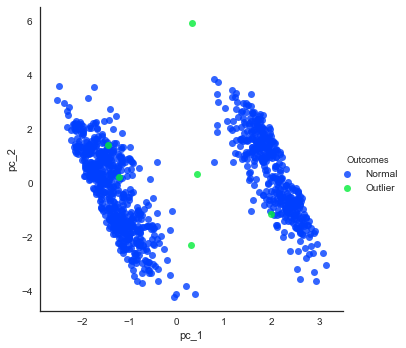

In [11]:
from sklearn.decomposition import PCA

#Set up the charts
%matplotlib inline 
plt.style.use('ggplot')
sns.set(style="white")

#Set up PCA
pca = PCA(n_components=2)

#Fit it to the data
pca.fit(all_users_scaled)

#How much of the variance is explained by the first two PC
print ("Explained variance (%)")
print(pca.explained_variance_ratio_) 

#Create a dataframe out of the rotated data and plot it
pc_df = pd.DataFrame(pca.transform(all_users_scaled))
pc_df.columns = ['pc_1', 'pc_2']
pal = sns.color_palette("bright", n_colors=4)


# A function for plotting outliers
def pca_plot(labels):
    chart_data = pc_df
    chart_data['pred_outlier'] = labels + 2 * all_users['outlier']
    g = sns.lmplot('pc_1','pc_2',data=chart_data,fit_reg=False,hue="pred_outlier",palette=pal)
    g._legend.set_title('Outcomes')
    return g
    
g = pca_plot(all_users["outlier"])

new_labels = ['Normal', 'Outlier']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

Even though only about 35% of the variance is captured in this two dimensional plot, some of the anomalies are still clearly visible as outliers.

Our task will be to identify all six cases without falsely identifying too many of the others

# The Techniques

As usual we will begin with the simplest approach and assess its drawbacks.

### A simple method based on quantiles

The most obvious way to detect outliers is simply to get the $\alpha$ and $1-\alpha$ quantiles for each variable and classify any observation that has a variable with a value outside of this range as an outlier. The problem is then how to choose $\alpha$? If we are happy that we can isolate a large training data set that has contains no outliers then we could just take maximum and minumim values from there (equivalent to setting $\alpha$ to zero). Alternatively we could pick a value that seems sensible (say $\alpha$ = 0.01). 

The difficulty is that a company will be flagged as an outlier if it fails to lie within the quantile for any of the variables which means that the proportion of the data flagged up for inspection will be much larger than 2*$\alpha$

Let's try it on our data...

Confusion matrix:
top left: true negatives, top right: false positives
bottom left: false negatives, bottom right: true positives
[[990  10]
 [  4   2]]
Precision: 0.167
Recall: 0.333


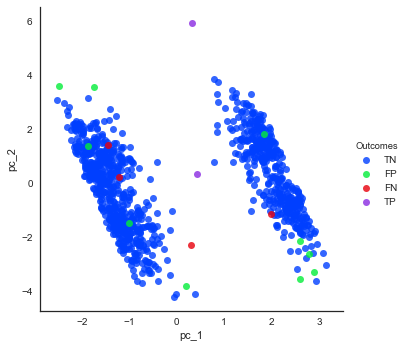

In [14]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

#Get the quantiles
quantiles = all_users.quantile(q=[0.001, 0.999])

#A function to identify outliers
def outlier_check(row):
    for i in range(5):
            if row[i] < quantiles.iloc[0,i] or row[i] > quantiles.iloc[1,i]:
                return 1
    return 0

pred_outlier = all_users.apply(outlier_check, axis = 1)   

def evaluate_technique(p):
    print ("Confusion matrix:")
    
    print("top left: true negatives, top right: false positives")
    print("bottom left: false negatives, bottom right: true positives")
    print(confusion_matrix(all_users.outlier, p))
    print("Precision: %1.3f" % precision_score(all_users.outlier, p))
    print("Recall: %1.3f" % recall_score(all_users.outlier, p))
    
evaluate_technique(pred_outlier)
g = pca_plot(pred_outlier)
new_labels = ['TN', 'FP', 'FN', 'TP']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

The key here is:

* 0 not identified as outlier (TN)
* 1 predicted as an outlier but not (FP)
* 2 an unidentified outlier (FN)
* 3 an identified outlier (TP)

As expected many more are flagged as outliers than actually are (we have 10 false positives). Also why did it fail to capture four of the cases? The answer is that they were unusual not because they contained extreme values but rather because they contained an unusual combination of values. Look at what happens when we plot income against age.


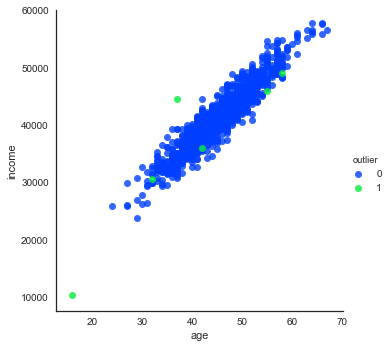

In [15]:
_ =sns.lmplot('age','income',data=all_users,fit_reg=False,hue="outlier",palette=pal)

We can see our age/income outlier very clearly. Neither the age value by itself nor the income value by itself are unusual. It is the combination and this is what is missed by the quantile method.

A similar thing is going on for gender and genre. More precision on bivariate methods over quantile methods.

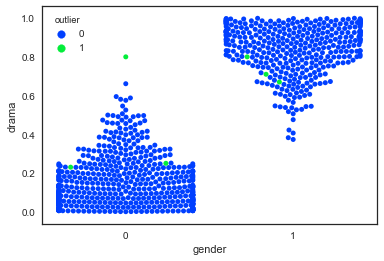

In [17]:
_ = sns.swarmplot('gender','drama',data=all_users,hue="outlier",palette=pal)

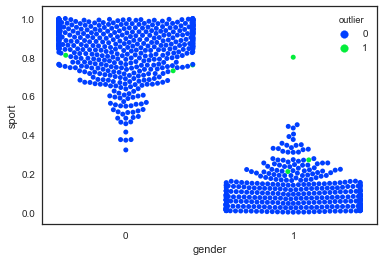

In [18]:
_ = sns.swarmplot('gender','sport',data=all_users,hue="outlier",palette=pal)

If we are to take into consideration combinations of values we will need to look at multivariate methods.

## Multivariate methods

The scatterplot above suggests that one way of capturing unusual combinations of values would be to use the distance from any point to its nearest neighbours. If a point is a long way from its neighbours (relative to a what could be considered normal for the data set) then we might class it as an outlier. This is the idea behind the **Local outlier factor** method. It's a little more complicated than that because it uses a distance metric called *reachability distance* to get more stable results, and because it allows for fluctuating densities. But the general idea is the same.

<img src="k_distance.png" width="600">

Think of it as a kind of smoothing. Any distance within *the core* is set to the same distance. 

(Note *reachability distance* is a key concept for the DBScan clustering algorithm)

Let's see how it does on our data set.

Confusion matrix:
top left: true negatives, top right: false positives
bottom left: false negatives, bottom right: true positives
[[998   2]
 [  2   4]]
Precision: 0.667
Recall: 0.667


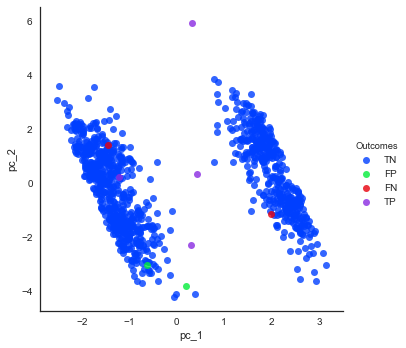

In [19]:
from sklearn.neighbors import LocalOutlierFactor

# fit the model
lof = LocalOutlierFactor(n_neighbors=10, contamination=0.005)
lof_pred = lof.fit_predict(all_users_scaled)
lof_pred = [(x-1)/(-2) for x in lof_pred.tolist()] #Converts a -1, 1 labelling system to 0, 1

evaluate_technique(lof_pred)
g = pca_plot(lof_pred)
new_labels = ['TN', 'FP', 'FN', 'TP']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

It does much better - identifying 4 of the 6 outliers and misclassifying only two 'normal' observations.

Another way of thinking about the failure of the quantile method to identify all of the outliers is to point out that it failed to take into account the covariance in the data. For example that between age and income. We could get round this by using another multivariate technique in sci-kit learn, **eliptic envelopes** , which seeks to fit a multivariate gaussian distribution to the data that captures this covariance. An outlier is then any observation that would be unusual given this multivariate distribution.

Confusion matrix:
top left: true negatives, top right: false positives
bottom left: false negatives, bottom right: true positives
[[995   5]
 [  5   1]]
Precision: 0.167
Recall: 0.167


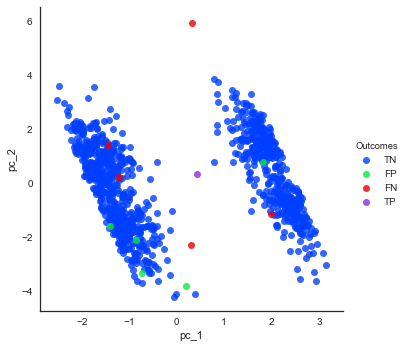

In [20]:
from sklearn.covariance import EllipticEnvelope
ee = EllipticEnvelope(support_fraction=1.,contamination=0.005)
ee.fit(all_users_scaled)
ee_pred = ee.predict(all_users_scaled)
ee_pred = [(x-1)/(-2) for x in ee_pred.tolist()] #Converts a -1, 1 labelling system to 0, 1
evaluate_technique(ee_pred)
g = pca_plot(ee_pred)
new_labels = ['TN', 'FP', 'FN', 'TP']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

It is unsurprising that it does less well than local outlier factor method since our data was not generated from a gaussian distribution.

A completley different approach is taken using **isolation forests**. A measure of abnormality is made for each point P by using the following algorithm.

1. Choose a variable at random
2. Choose a splitting point for that variable at random (between the min and max values of the variable)
3. Partition the data by splitting at this point
4. Repeat until point P has been isolated.
5. Record the number of splits needed to isolate the variable

The intution is that it won't take many splits to isolate an outlier. The splitting process can be represented diagramatically as a tree. Many trees are then generated for each point and the average tree length is taken as a measure of abnormality.

Confusion matrix:
top left: true negatives, top right: false positives
bottom left: false negatives, bottom right: true positives
[[996   4]
 [  4   2]]
Precision: 0.333
Recall: 0.333


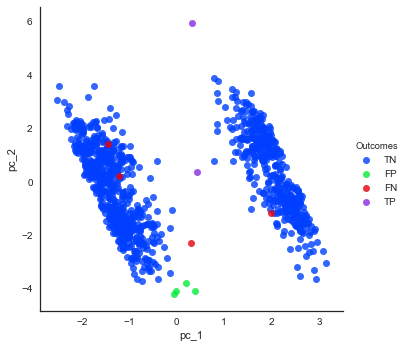

In [21]:
from sklearn.ensemble import IsolationForest

# fit the model
isf = IsolationForest(max_samples=200, contamination=0.005)
isf.fit(all_users_scaled)
isf_pred = isf.predict(all_users_scaled)
isf_pred = [(x-1)/(-2) for x in isf_pred.tolist()]
evaluate_technique(isf_pred)
g = pca_plot(isf_pred)
new_labels = ['TN', 'FP', 'FN', 'TP']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

So this performs as well as LOF (on our very small test set)

Finally we will consider **One class Support Vector Machines**. This is a difficult method to understand unless you first have a good understanding of Support Vector Machines as classifiers. I will do by best very briefly on the white board!

Confusion matrix:
top left: true negatives, top right: false positives
bottom left: false negatives, bottom right: true positives
[[950  50]
 [  3   3]]
Precision: 0.057
Recall: 0.500


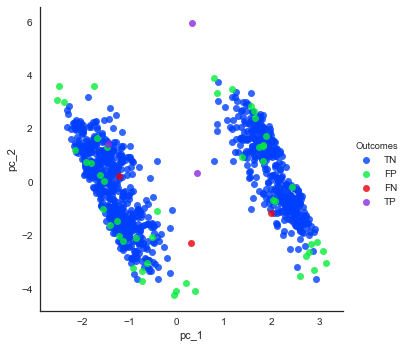

In [22]:
from sklearn import svm
ocsvm = svm.OneClassSVM(nu=0.95 * 0.001 + 0.05, kernel="rbf", gamma=0.1)
ocsvm.fit(all_users_scaled)
ocsvm_pred = ocsvm.predict(all_users_scaled)
ocsvm_pred = [(x-1)/(-2) for x in ocsvm_pred.tolist()]
evaluate_technique(ocsvm_pred)
g = pca_plot(ocsvm_pred)
new_labels = ['TN', 'FP', 'FN', 'TP']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

Clearly not great - although it could be improved by tuning.

So far we have assumed that it's not possible to create a dataset of 'normal' cases and train our anomaly detection methods on that instead of on the contaminated data. To be fair we should also test our techniques in this more optimistic scenario (note it is irrelevant for IOF and Isolation Forests)

#### Create some uncontaminated data

Train on the uncontaminated data and test on the contaminated data

In [23]:
hours_viewed_per_week = np.random.lognormal(1.5, 1., num_users).astype('int')
pct_on_mobile = np.random.beta(1,1,num_users) # uniform
age = np.random.poisson(45,num_users)
income = 5000 + 800 * age +  np.random.normal(0, 2000, num_users) #Creating some correlation
gender = np.random.binomial(1,0.4,num_users)
#Adding relationship between demographics and genre viewing
drama = np.random.beta(1,3,num_users)
num_female = drama[gender==1].shape[0]
drama[gender==1] = np.random.beta(5,1,num_female)
sport = np.random.beta(6,1,num_users)
sport[gender==1] = np.random.beta(1,8,num_female)
comedy = np.random.beta(3,1,num_users)
num_45_plus= age[age>45].shape[0]
comedy[age>45] = np.random.beta(1,3,num_45_plus)


uncontaminated = pd.DataFrame({'age': age,'gender': gender,'income': income, 
                               'hours_viewed_per_week': hours_viewed_per_week,'pct_on_mobile': pct_on_mobile,
                               'drama': drama,'sport': sport,'comedy': comedy,'outlier': [0]*num_users
    })

uncontaminated_scaled = preprocessing.scale(uncontaminated.drop(['outlier'] , axis=1))

In [24]:
#Get the quantiles
quantiles = uncontaminated.quantile(q=[0.001, 0.999])

#A function to identify outliers
def outlier_check(row):
    for i in range(5):
            if row[i] < quantiles.iloc[0,i] or row[i] > quantiles.iloc[1,i]:
                return 1
    return 0

pred_outlier = all_users.apply(outlier_check, axis = 1)   

evaluate_technique(pred_outlier)

Confusion matrix:
top left: true negatives, top right: false positives
bottom left: false negatives, bottom right: true positives
[[991   9]
 [  4   2]]
Precision: 0.182
Recall: 0.333


#### Eliptic Envelopes

In [25]:
ee.fit(uncontaminated_scaled)
ee_pred = ee.predict(all_users_scaled)
ee_pred = [(x-1)/(-2) for x in ee_pred.tolist()]
evaluate_technique(ee_pred)

Confusion matrix:
top left: true negatives, top right: false positives
bottom left: false negatives, bottom right: true positives
[[999   1]
 [  5   1]]
Precision: 0.500
Recall: 0.167


In [26]:
ocsvm.fit(uncontaminated_scaled)
ocsvm_pred = ocsvm.predict(all_users_scaled)
ocsvm_pred = [(x-1)/(-2) for x in ocsvm_pred.tolist()]
evaluate_technique(ocsvm_pred)

Confusion matrix:
top left: true negatives, top right: false positives
bottom left: false negatives, bottom right: true positives
[[938  62]
 [  3   3]]
Precision: 0.046
Recall: 0.500


Apart from some improvement to the precision of one class SVM it makes little difference!

Now if there's any time left try adding your own randomly generated variables to the data set and repeating the analysis.